In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 784
hidden_size1 = 500
hidden_size2 = 125
num_class = 10
batch_size = 100
learning_rate = 0.001


train_dataset = torchvision.datasets.MNIST(root='./MNISTdatset', train = True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./MNISTdataset', train = False, transform=torchvision.transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle=False)

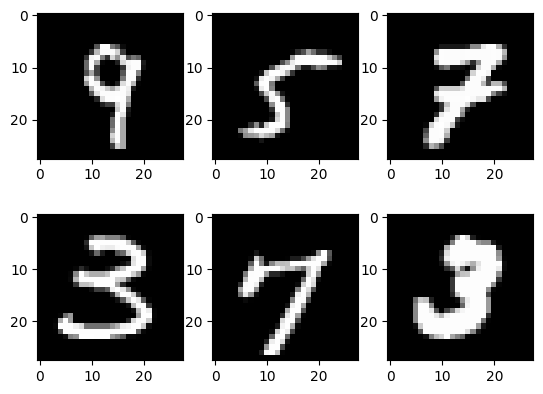

In [2]:
it = iter(train_loader)
data,target = next(it)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(data[i][0], cmap = 'gray')

In [3]:
class NNet (torch.nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, num_class):
        super().__init__()
        self.l1 = torch.nn.Linear(input_size, hidden_size1)
        self.l2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.l3 = torch.nn.Linear(hidden_size2, num_class)

    def forward(self, x):
        return self.l3(torch.relu(self.l2(torch.relu(self.l1(x)))))

model = NNet(input_size, hidden_size1, hidden_size2, num_class).to(device)
l = torch.nn.CrossEntropyLoss()
update = torch.optim.Adam(model.parameters(), lr = learning_rate)

plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'c', 'm']

<Figure size 1000x600 with 0 Axes>

Avg Loss per epoch 1 = 0.2856
Avg Loss per epoch 2 = 0.1054
Avg Loss per epoch 3 = 0.0671
Avg Loss per epoch 4 = 0.0473
Avg Loss per epoch 5 = 0.0358


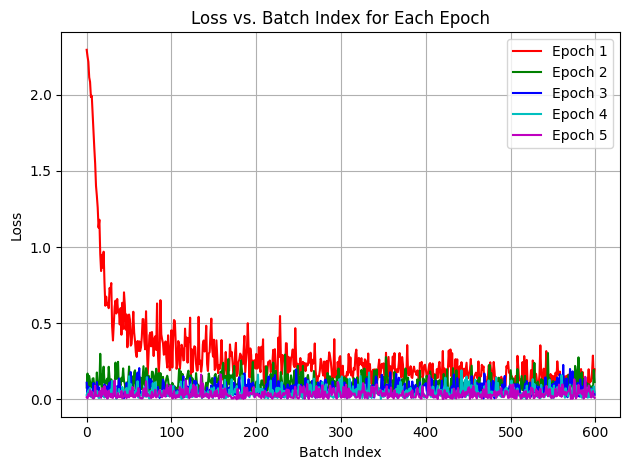

In [4]:
for j in range(5):
    batch_losses = []
    tl = 0
    for i , (img, lbl) in enumerate(train_loader):
        img = img.reshape(-1,28*28).to(device)
        lbl = lbl.to(device)

        out = model(img)
        loss = l(out,lbl)
        loss.backward()
        update.step()
        update.zero_grad()
        tl += loss.item()
        batch_losses.append(loss.item())


    plt.plot(batch_losses, color=colors[j % len(colors)], label=f'Epoch {j+1}')
    print(f'Avg Loss per epoch {j+1} = {(tl/len(train_loader)):.4f}')



plt.title('Loss vs. Batch Index for Each Epoch')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
all_preds = []
all_labels = []
with torch.no_grad():
    crct = 0
    total = len(test_loader.dataset)
    for img,lbl in test_loader:
        img = img.reshape(-1,28*28).to(device)
        lbl = lbl.to(device)

        out = model(img)
        _,prediction = torch.max(out,1)
        crct += (prediction==lbl).sum().item()

        all_preds.extend(prediction.cpu().numpy())
        all_labels.extend(lbl.cpu().numpy())






print(f'Accuracy: {(crct/total*100):.3f}')

Accuracy: 97.520


<Figure size 1000x800 with 0 Axes>

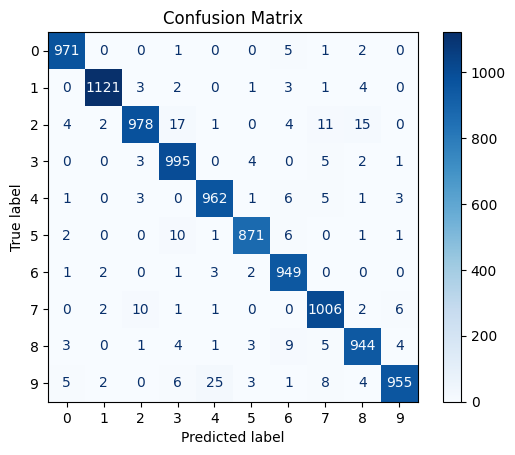

In [6]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

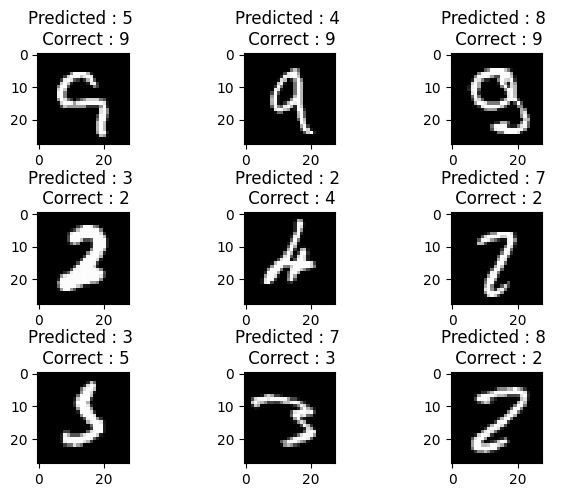

In [7]:
wrong_img =[]
wrong_pred = []
wrong_trues = []
with torch.no_grad():
    for image, label in test_loader:
        image_flat = image.reshape(-1,28*28).to(device)
        label = label.to(device) 
        output = model(image_flat)


        _,prediction = torch.max(output,1)

        wrong = prediction != label

        if wrong.sum() > 0:
            wrong_img.extend(image[wrong.cpu()])
            wrong_pred.extend(prediction[wrong.cpu()])
            wrong_trues.extend(label[wrong.cpu()])
        if len(wrong_img) > 8: break


for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(wrong_img[i][0], cmap = 'gray')
    plt.title(f'Predicted : {wrong_pred[i]} \n Correct : {wrong_trues[i]}')

plt.tight_layout(pad=0.1)
plt.show()